In [ ]:
#abc

In [ ]:
! install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

install: missing destination file operand after 'kaggle'
Try 'install --help' for more information.


In [ ]:
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

satellite-images-of-water-bodies.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip satellite-images-of-water-bodies.zip

Archive:  satellite-images-of-water-bodies.zip
replace Water Bodies Dataset/Images/water_body_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.datasets import load_files
import matplotlib.image as mpimg
import os
import tensorflow as tf
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import np_utils

# **Data exploration :**

In [2]:
images_path = '/content/Water Bodies Dataset/Images/'
masks_path = '/content/Water Bodies Dataset/Masks/'

In [3]:
images_names = sorted(next(os.walk(images_path))[-1])
masks_names = sorted(next(os.walk(masks_path))[-1])

In [4]:
images_names == masks_names

True

In [5]:
# load_img(images_path +images_names[0])

In [6]:
a = load_img(images_path+images_names[0])
type(a)

PIL.JpegImagePlugin.JpegImageFile

In [7]:
img = img_to_array(a).astype('float')/255.

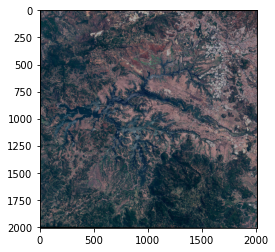

In [8]:
plt.imshow(img)

In [9]:
type(images_path)

str

In [10]:
SIZE = 256
images = np.zeros(shape=(len(images_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(images_names),SIZE, SIZE, 1))

for id in range(len(images_names)):
  path ='/content/Water Bodies Dataset/Images/'+ images_names[id]
  img = load_img(path)
  img = img_to_array(img).astype('float')/255.
  img = cv2.resize(img, (SIZE,SIZE), cv2.INTER_AREA)
  images[id] = img

for id in range(len(masks_names)):
  path = '/content/Water Bodies Dataset/Masks/' + masks_names[id]
  mask = load_img(path)
  mask = img_to_array(mask).astype('float')/255.
  mask = cv2.resize(mask, (SIZE,SIZE), cv2.INTER_AREA)
  masks[id] = mask[:,:,:1]

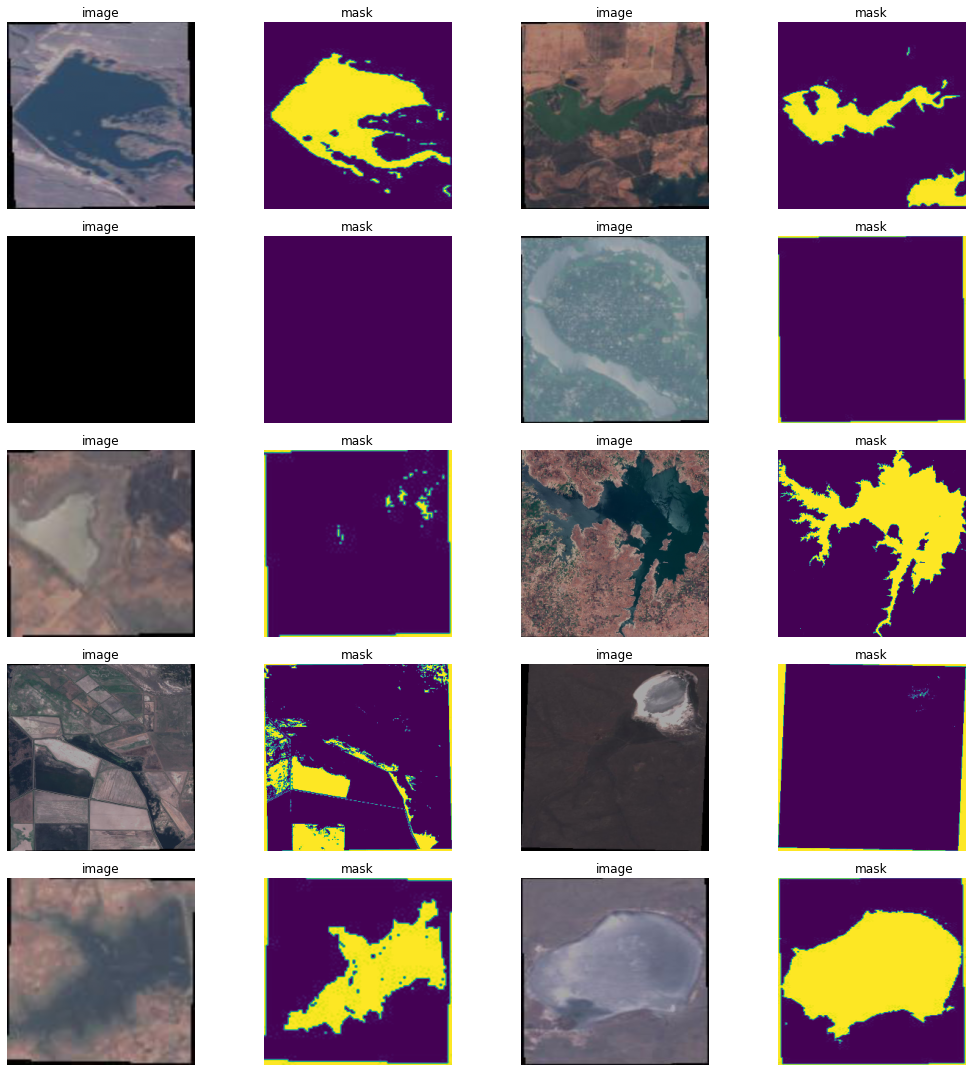

In [11]:
plt.figure(figsize=(15,15))
for i in range(1,21):
  plt.subplot(5,4,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    plt.imshow(images[id])
    plt.title('image')
    plt.axis('off')
  elif i%2==0:
    plt.imshow(masks[id].reshape(256,256))
    plt.title('mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

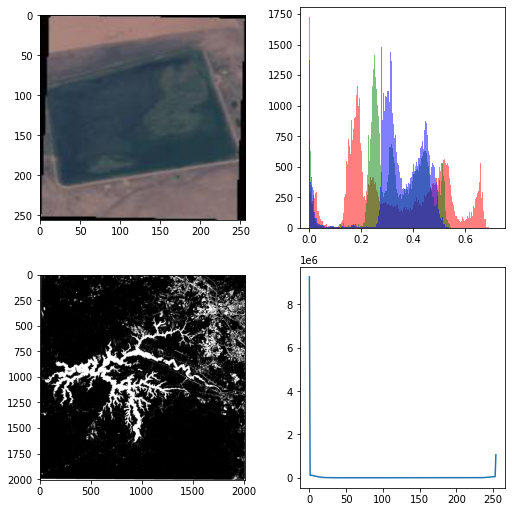

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7), constrained_layout=True)
example_image, example_mask = load_img('/content/Water Bodies Dataset/Images/'+ images_names[0]) , load_img('/content/Water Bodies Dataset/Masks/'+ masks_names[0])
example_image = np.array(example_image).astype('float')/255.
example_image = cv2.resize(img, (SIZE,SIZE), cv2.INTER_AREA)
example_mask = np.squeeze(example_mask)
axs[0][0].imshow(example_image)
axs[0][1].hist(example_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
axs[0][1].hist(example_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
axs[0][1].hist(example_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)

axs[1][0].imshow(example_mask)
histogram, bin_edges = np.histogram(example_mask, bins=256)
axs[1][1].plot(bin_edges[0:-1], histogram)

the pixels of the mask are not binary but float so we are going to descritisize them in order to have better results .
in addition , we can notice that the constrast of the images is low , so we can increase it by equalizing the histogram i.e spreading out the most frequent intensity values .

In [13]:
img1 = cv2.imread('/content/Water Bodies Dataset/Images/'+ images_names[25])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img1, cv2.COLOR_BGR2YCrCb)
img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
equalized_img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)

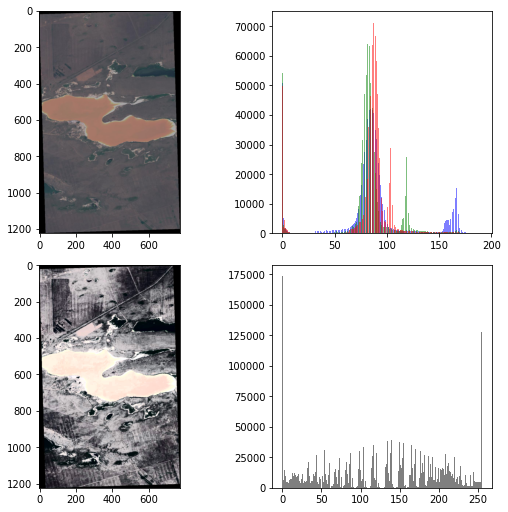

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7), constrained_layout=True)
example_image = img1 
axs[0][0].imshow(example_image)
axs[0][1].hist(example_image[:,:,0].flatten(), 256, color = 'blue', alpha = 0.5)
axs[0][1].hist(example_image[:,:,1].flatten(), 256, color = 'Green', alpha = 0.5)
axs[0][1].hist(example_image[:,:,2].flatten(), 256, color = 'red', alpha = 0.5)
axs[1][0].imshow(equalized_img)
axs[1][1].hist(equalized_img.flatten(), 256, color = 'black', alpha = 0.5)
histogram, bin_edges = np.histogram(example_mask, bins=256)

# **Preprocessing the data :**

In [15]:
#resizing and rescaling :
img_size = (128 , 128)
images = tf.image.resize(images, img_size)
images = tf.cast(images, tf.float32) / 255.0
masks = tf.image.resize(masks, img_size)
masks = tf.cast(masks, tf.float32) / 255.0

In [16]:
def eq(image):  
  image = cv2.imread('/content/Water Bodies Dataset/Images/' + image)
  img = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
  img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
  equalized_img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
  return equalized_img

In [17]:
images_dataset = [eq(i) for i in images_names]

In [18]:
masks_dataset = [i for i in masks_names]

In [19]:
images_dataset == masks_dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


False

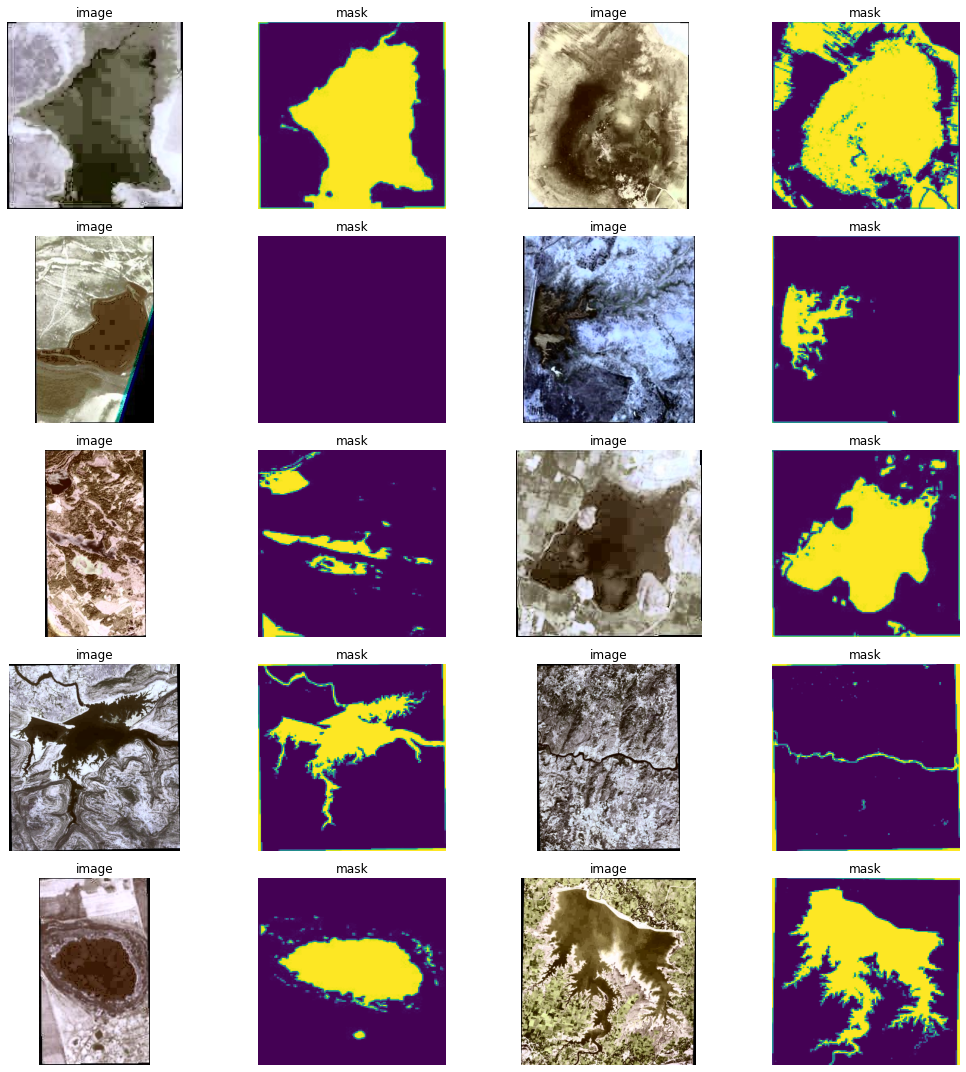

In [20]:
plt.figure(figsize=(15,15))
for i in range(1,21):
  plt.subplot(5,4,i)

  if i%2!=0:
    id = np.random.randint(len(images_dataset))
    plt.imshow(images_dataset[id])
    plt.title('image')
    plt.axis('off')
  elif i%2==0:
    plt.imshow(tf.reshape(masks[id] , (128 , 128)))
    plt.title('mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Building the model (U-Net) :**